In [39]:
import yfinance as yf
import pandas as pd   #python library for data analysis and manipulation
from sklearn.metrics import precision_score

import os

In [40]:
vfv = yf.Ticker("VFV.TO")
vfv = vfv.history(period="max")

In [41]:
vfv.index = pd.to_datetime(vfv.index, utc=True)

In [42]:
#delete these columns
del vfv["Dividends"]
del vfv["Stock Splits"]

In [43]:
vfv

,Open,High,Low,Close,Volume,Capital Gains
Date,,,,,,
2012-11-08 05:00:00+00:00,20.602004,20.602004,20.568682,20.568682,4400,0.0
2012-11-09 05:00:00+00:00,20.410392,20.568677,20.402061,20.493700,2900,0.0
2012-11-12 05:00:00+00:00,20.493709,20.493709,20.468716,20.468716,1200,0.0
2012-11-13 05:00:00+00:00,20.410401,20.543693,20.410401,20.477047,4600,0.0
2012-11-14 05:00:00+00:00,20.352084,20.352084,20.335423,20.335423,2600,0.0
...,...,...,...,...,...,...
2025-05-23 04:00:00+00:00,141.589996,142.000000,141.179993,141.410004,362400,0.0
2025-05-26 04:00:00+00:00,142.669998,143.770004,142.669998,143.580002,109000,0.0
2025-05-27 04:00:00+00:00,143.619995,145.309998,143.169998,145.279999,172800,0.0


<Axes: xlabel='Date'>

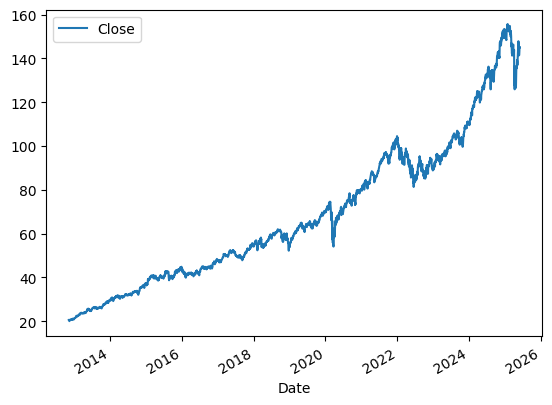

In [44]:
vfv.plot.line(y="Close", use_index=True)


In [45]:
print(vfv.head())
#volume: num of shares traded per day
#Capital gains: usually 0 unless a distribution is recorded
#Date: starts from 2012, which is when VFV launched. VFV ETF officially launched on November 2, 2012.


                                Open       High        Low      Close  Volume  \
Date                                                                            
2012-11-08 05:00:00+00:00  20.602004  20.602004  20.568682  20.568682    4400   
2012-11-09 05:00:00+00:00  20.410392  20.568677  20.402061  20.493700    2900   
2012-11-12 05:00:00+00:00  20.493709  20.493709  20.468716  20.468716    1200   
2012-11-13 05:00:00+00:00  20.410401  20.543693  20.410401  20.477047    4600   
2012-11-14 05:00:00+00:00  20.352084  20.352084  20.335423  20.335423    2600   

                           Capital Gains  
Date                                      
2012-11-08 05:00:00+00:00            0.0  
2012-11-09 05:00:00+00:00            0.0  
2012-11-12 05:00:00+00:00            0.0  
2012-11-13 05:00:00+00:00            0.0  
2012-11-14 05:00:00+00:00            0.0  


In [46]:
#start predictions
vfv["Tomorrow"] = vfv["Close"].shift(-1)

In [47]:
print(vfv.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Capital Gains', 'Tomorrow'], dtype='object')


In [48]:
vfv["Target"] = (vfv["Tomorrow"] > vfv["Close"]).astype(int)

In [49]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=100,
    random_state=1
)

# Split data into training and testing sets
train = vfv.iloc[:-100]
test = vfv.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]

#Train the model
model.fit(train[predictors], train["Target"])

#expected output: Python printing the model object to confirm how it is configured

RandomForestClassifier(min_samples_split=100, random_state=1)

In [50]:
#precision measures: percentage of correctness when the model predicts "up"
from sklearn.metrics import accuracy_score, recall_score
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

print("Accuracy:", accuracy_score(test["Target"], preds))   #percentage of overall correctness of the mdodel
print("Recall:  ", recall_score(test["Target"], preds))     #of all upward moves, the model catches roughly 70% of it; i.e. model is good at not missing upward moves


Accuracy: 0.56
Recall:   0.7291666666666666


<Axes: title={'center': 'Actual vs Predicted VFV Direction'}, xlabel='Date'>

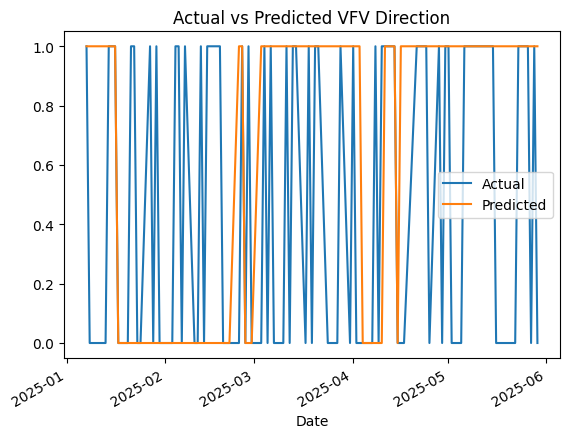

In [51]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.columns = ["Actual", "Predicted"]
combined.plot(title="Actual vs Predicted VFV Direction")


Explanation of the graph:


*   There are two lines shown on the graph: 'Actual' (in blue) and 'Predicted' (in orange)
*   1 = model predicts price will go up
*0 = model predicts price will go down





In [52]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [53]:
def backtest(data, model, predictors, start=300, step=50):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)


In [54]:
predictions = backtest(vfv, model, predictors)
predictions["Predictions"].value_counts()


,count
Predictions,
0,1645
1,1205


In [55]:
print("VFV Backtest Precision:", precision_score(predictions["Target"], predictions["Predictions"]))


VFV Backtest Precision: 0.5609958506224066


In [56]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.544912
0,0.455088


In [57]:
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = vfv.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    vfv[ratio_column] = vfv["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    vfv[trend_column] = vfv.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]


In [58]:
vfv = vfv.dropna(subset=vfv.columns[vfv.columns != "Tomorrow"])
vfv


,Open,High,Low,Close,Volume,Capital Gains,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,
2016-11-03 04:00:00+00:00,44.355940,44.364810,44.080932,44.098675,17000,0.0,44.107552,1,0.997392,0.0,0.989293,1.0,0.990031,29.0,1.025973,121.0,1.275344,535.0
2016-11-04 04:00:00+00:00,44.267233,44.391429,44.107552,44.107552,44200,0.0,44.959190,1,1.000101,1.0,0.992851,2.0,0.990413,30.0,1.026114,121.0,1.274730,536.0
2016-11-07 05:00:00+00:00,44.781766,44.968060,44.657570,44.959190,64000,0.0,44.905952,0,1.009562,2.0,1.012183,2.0,1.009401,31.0,1.045737,122.0,1.298424,537.0
2016-11-08 05:00:00+00:00,44.879340,45.172087,44.799499,44.905952,18500,0.0,45.651134,1,0.999408,1.0,1.009573,2.0,1.008048,31.0,1.044314,121.0,1.295972,536.0
2016-11-09 05:00:00+00:00,44.843856,45.908400,44.843856,45.651134,134500,0.0,46.130180,1,1.008229,1.0,1.020262,3.0,1.024322,32.0,1.061371,122.0,1.316516,537.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23 04:00:00+00:00,141.589996,142.000000,141.179993,141.410004,362400,0.0,143.580002,1,0.991655,0.0,0.976980,1.0,1.008576,30.0,1.004300,137.0,1.291587,554.0
2025-05-26 04:00:00+00:00,142.669998,143.770004,142.669998,143.580002,109000,0.0,145.279999,1,1.007614,1.0,0.997859,1.0,1.024825,31.0,1.019247,137.0,1.310716,555.0
2025-05-27 04:00:00+00:00,143.619995,145.309998,143.169998,145.279999,172800,0.0,144.750000,0,1.005885,2.0,1.011798,2.0,1.037860,31.0,1.030788,138.0,1.325516,556.0


In [60]:
from sklearn.ensemble import RandomForestClassifier

# Updated model with new parameters
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

# Updated predict function using probability threshold
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:, 1]   # Probability of class 1 (up)

    preds[preds >= 0.6] = 1    # Only label as "up" if confidence >= 60%
    preds[preds < 0.6] = 0     # Otherwise label as "down"

    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

# Backtest using new predictors
predictions = backtest(vfv, model, new_predictors)

# Count how often model predicted up/down
predictions["Predictions"].value_counts()


,count
Predictions,
0.0,1427
1.0,423


In [61]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5602836879432624

In [62]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.556757
0,0.443243


In [63]:
predictions

,Target,Predictions
Date,,
2018-01-16 05:00:00+00:00,1,0.0
2018-01-17 05:00:00+00:00,0,1.0
2018-01-18 05:00:00+00:00,1,1.0
2018-01-19 05:00:00+00:00,1,0.0
2018-01-22 05:00:00+00:00,1,0.0
...,...,...
2025-05-23 04:00:00+00:00,1,0.0
2025-05-26 04:00:00+00:00,1,0.0
2025-05-27 04:00:00+00:00,0,0.0
